# fit.kn2all.ipynb
- fitting kilonova observational data to the other models

In [46]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import sncosmo

In [47]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [48]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth

from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_lsst_bandwidth
lsstbdw = get_lsst_bandwidth()

In [49]:
from scipy.optimize import curve_fit
def func(x, a):
	return a*x
def calc_chisquare(obs, exp):
	return np.sum((obs-exp)**2/exp)

In [72]:
def extract_fnu_from_simulation(psimtbl):
	fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if filte != 't']
	return fnuabs

def extract_fnu_anwr_from_observation(pobstbl):
	fnuabs_anwr = [(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte]
	return fnuabs_anwr

def extract_fnu_from_observation(pobstbl):
	fnuobs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte]
	fnuobserr = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuerr_' in filte]
	return fnuobs, fnuobserr

In [51]:
# magoffset = -2.5*np.log10(54)
magoffset = -4.3
print(f"Apply magnitude offset ({magoffset:1.3f} mag)")

Apply magnitude offset (-4.300 mag)


In [228]:
knsimphtmedlist = sorted(glob.glob('../3.table/kn_sim_cube_synphot/*_lsst.ecsv'))
snsimphtmedlist = sorted(glob.glob('../3.table/sn_sim_sncosmo_synphot/*_sn_z*lsst.ecsv'))
snsimphtmedlist[:10]

['../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.001_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.01_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.1_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z1.0_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/nugent-sn1bc_v1.1_type_Ib_sn_z0.0001_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/nugent-sn1bc_v1.1_type_Ib_sn_z0.001_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/nugent-sn1bc_v1.1_type_Ib_sn_z0.01_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/nugent-sn1bc_v1.1_type_Ib_sn_z0.1_synphot_lsst.ecsv',
 '../3.table/sn_sim_sncosmo_synphot/nugent-sn1bc_v1.1_type_Ib_sn_z1.0_synphot_lsst.ecsv']

- SN color

In [233]:
bd0 = 'g'
bd1 = 'r'
bd2 = 'i'

tablelist = []

#	Comparison
for nn, snsimphtmed in enumerate(snsimphtmedlist):
	simtbl = ascii.read(snsimphtmed)
	times_sim = np.unique(simtbl['t'])

	_ = Table()
	_['model name'] = [snsimphtmed]*len(times_sim)
	_['t'] = times_sim
	# _['z'] = simtbl.meta['z']
	grmed_cmp = simtbl[bd0]-simtbl[bd1]
	rimed_cmp = simtbl[bd1]-simtbl[bd2]

	_[f'{bd0}-{bd1}'] = grmed_cmp
	_[f'{bd1}-{bd2}'] = rimed_cmp

	tablelist.append(_)

snclrtbl = vstack(tablelist)
snclrtbl.write(f"../3.table/sn.sncosmo.color.gri.ecsv", format='ascii.ecsv', overwrite=True)
snclrtbl[:5]

model name,t,g-r,r-i
,d,mag(AB),mag(AB)
str92,float64,float64,float64
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_lsst.ecsv,-5.0,-0.199,-0.357
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_lsst.ecsv,0.0,-0.149,-0.605
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_lsst.ecsv,5.0,-0.117,-0.728
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_lsst.ecsv,10.0,-0.126,-0.760
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_lsst.ecsv,15.0,-0.049,-0.668


- KN color

In [54]:
bd0 = 'g'
bd1 = 'r'
bd2 = 'i'

tablelist = []

#	Comparison
for nn, snsimphtmed in enumerate(knsimphtmedlist):
	print(f"[{nn+1}/{len(knsimphtmedlist)}] {os.path.basename(snsimphtmed)}", end='\r')

	simtbl = ascii.read(snsimphtmed)
	times_sim = np.unique(simtbl['t'])

	_ = Table()
	_['model name'] = [snsimphtmed]*len(times_sim)
	_['t'] = times_sim
	_['z'] = 0.0
	grmed_cmp = simtbl[bd0]-simtbl[bd1]
	rimed_cmp = simtbl[bd1]-simtbl[bd2]

	_[f'{bd0}-{bd1}'] = grmed_cmp
	_[f'{bd1}-{bd2}'] = rimed_cmp

	tablelist.append(_)

knclrtbl = vstack(tablelist)
knclrtbl.write(f"../3.table/kn.sim_cube.color.gri.ecsv", format='ascii.ecsv', overwrite=True)
knclrtbl[:5]

model name,t,z,g-r,r-i
,d,,mag(AB),mag(AB)
str118,float64,float64,float64,float64
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst.ecsv,0.125,0.0,0.362,-0.371
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst.ecsv,0.136,0.0,0.112,-0.225
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst.ecsv,0.149,0.0,-0.032,-0.112
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst.ecsv,0.162,0.0,0.041,-0.123
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst.ecsv,0.177,0.0,0.115,-0.143


# Bulk

In [230]:
knobsphtmedlist = sorted(glob.glob("../5.result/kn_sim_cube_obs/sdss_40Mpc/Run*sdss.ecsv"))
snsimphtmedlist = sorted(glob.glob('../3.table/sn_sim_sncosmo_synphot/*sn_z*_synphot_lsst.ecsv'))
print(f"KN {len(knobsphtmedlist)}\tSN {len(snsimphtmedlist)}")

KN 6300	SN 50


In [231]:
times = np.unique(ascii.read(knobsphtmedlist[0])['t'])
indx_time = np.array([0, 8, 16, 24,])
list(times[indx_time])

[0.125, 0.25, 0.5, 1.0]

- select similar color

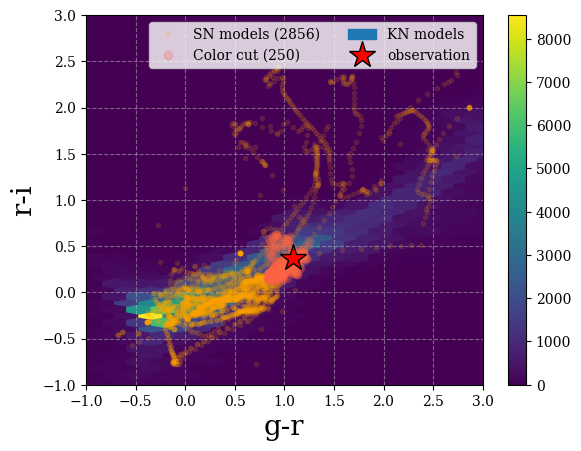

In [57]:
knobsphtmed = knobsphtmedlist[-4]
obstbl = ascii.read(knobsphtmed)

t = 1.0
seed = 0.0

pobstbl = obstbl[
	(obstbl['t']==t) &
	(obstbl['seed']==seed)
]

gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()

# print(gr, ri)

#	Color tolerence
colortol = 0.25

indx_clr = np.where(
	(snclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
	(snclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
	(snclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
	(snclrtbl[f"{bd1}-{bd2}"]<ri+colortol)
)

# snclrtbl[indx_clr]

plt.plot(snclrtbl[f"{bd0}-{bd1}"], snclrtbl[f"{bd1}-{bd2}"], ls='none', marker='.', c='orange', alpha=0.125, label=f'SN models ({len(snclrtbl)})')
plt.plot(snclrtbl[f"{bd0}-{bd1}"][indx_clr], snclrtbl[f"{bd1}-{bd2}"][indx_clr], ls='none', marker='o', c='tomato', alpha=0.25, label=f'Color cut ({len(snclrtbl[indx_clr])})')

plt.hexbin(knclrtbl[f"{bd0}-{bd1}"], knclrtbl[f"{bd1}-{bd2}"], gridsize=70, label='KN models')
cbar = plt.colorbar()
# plt.plot(knclrtbl[f"{bd0}-{bd1}"], knclrtbl[f"{bd1}-{bd2}"], ls='none', marker='.', c='green', alpha=0.125, label=f'All ({len(knclrtbl)})')
# plt.plot(knclrtbl[f"{bd0}-{bd1}"][indx_clr], knclrtbl[f"{bd1}-{bd2}"][indx_clr], ls='none', marker='o', alpha=0.125, label=f'Color cut ({len(snclrtbl[indx_clr])})')


plt.plot(gr, ri, marker='*', mec='k', ms=20, color='red', ls='none', label='observation')
plt.legend(ncol=2)
plt.xlim([-1, 3])
plt.ylim([-1, 3])
# plt.xlim([-1, 2])
# plt.ylim([-1, 2])
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.grid('both', ls='--', c='silver', alpha=0.5)

## Test

In [234]:
d = 40
colortol = 0.1
timetol = 0.05

fittablelist = []
for jj, knobsphtmed in enumerate(knobsphtmedlist):
	print(f"[{jj+1}/{len(knobsphtmedlist)}] {os.path.basename(knobsphtmed)}", end='\r')

	obstbl = ascii.read(knobsphtmed)

	keylist = []
	for key in obstbl.keys():
		if ('t' in key) | ('seed' in key) | ('_g' in key) | ('_r' in key) | ('_i' in key):
			keylist.append(key)
	obstbl = obstbl[keylist]

	seeds = np.unique(obstbl['seed'])
	times = np.unique(obstbl['t'])

	ss = 0
	seed = seeds[ss]
	#	Save the fitting result
	tmptbl = Table()
	tmptbl['seed'] = [seed]*len(times[indx_time])
	tmptbl['obs'] = os.path.basename(knobsphtmed)
	tmptbl['t'] = times[indx_time]
	##	Empty Table
	###	KN
	tmptbl['kn_bestfit'] = ' '*200
	tmptbl['kn_t'] = 0.0
	tmptbl['kn_chisq'] = 0.0
	tmptbl['kn_popt'] = 0.0
	###	SN
	tmptbl['sn_bestfit'] = ' '*200
	tmptbl['sn_t'] = 0.0
	tmptbl['sn_chisq'] = 0.0
	tmptbl['sn_popt'] = 0.0
	###
	tmptbl['identification'] = False

	ntimes = times[indx_time]
	# tt = 0
	# t = ntimes[tt]
	for tt, t in enumerate(ntimes):
		pobstbl = obstbl[
			(obstbl['t']==t) &
			(obstbl['seed']==seed)
		]
		#	Fitting for the truth
		fnuabs_anwr0 = extract_fnu_anwr_from_observation(pobstbl)
		fnuobs0, fnuobserr0 = extract_fnu_from_observation(pobstbl)
		popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr0, fnuobs0, sigma=fnuobserr0, absolute_sigma=True,)

		chisq_anwr = calc_chisquare(
			obs=fnuabs_anwr0*popt_anwr,
			exp=fnuobs0,
		)

		#	Color cut
		gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
		ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()
		#	Color tolerence
		##	Other transients
		indx_clr = np.where(
			(snclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
			(snclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
			(snclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
			(snclrtbl[f"{bd1}-{bd2}"]<ri+colortol)
		)
		sncmpmodels = snclrtbl['model name'][indx_clr]
		sncmptimes = snclrtbl['t'][indx_clr]

		if len(sncmpmodels) > 0:
			snchisqlist = []
			snpoptlist = []
			for nn, (snsimphtmed, t_sim) in enumerate(zip(sncmpmodels, sncmptimes)):
				simtbl = ascii.read(snsimphtmed)
				simtbl = simtbl['t', 'g', 'r', 'i']
				times_sim = np.unique(simtbl['t'])
				#	From psimtbl
				psimtbl = simtbl[(simtbl['t']==t_sim)]
				fnuabs = extract_fnu_from_simulation(psimtbl)
				#	not NaN value
				indx_avail = np.array([i for i, val in enumerate(fnuabs) if not(np.isnan(val))])
				fnuabs = np.array(fnuabs)[indx_avail]
				fnuobs = np.array(fnuobs0)[indx_avail]
				fnuobserr = np.array(fnuobserr0)[indx_avail]
				fnuabs_anwr = np.array(fnuabs_anwr0)[indx_avail]

				popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
				chisq = calc_chisquare(
					obs=fnuabs*popt,
					exp=fnuobs,
					)
				snchisqlist.append(chisq)
				snpoptlist.append(popt[0])
			#	Find best-fit
			snchisqarr = np.array(snchisqlist)
			snchisqmin = snchisqarr.min()
			snbestmdl = sncmpmodels[snchisqarr==snchisqmin].item()
			snbestt = sncmptimes[snchisqarr==snchisqmin].item()
			snpopt = np.array(snpoptlist)[snchisqarr==snchisqmin].item()
		else:
			snchisqmin = None
			snbestmdl = None
			snbestt = None
			snpopt = None

		##	Kilonova
		indx_clr = np.where(
			(knclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
			(knclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
			(knclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
			(knclrtbl[f"{bd1}-{bd2}"]<ri+colortol) &
			(knclrtbl["t"]>t-timetol) &
			(knclrtbl["t"]<t+timetol)
		)
		kncmpmodels = knclrtbl['model name'][indx_clr]
		kncmptimes = knclrtbl['t'][indx_clr]

		if len(kncmpmodels) > 0:
			knchisqlist = []
			knpoptlist = []
			for nn, (snsimphtmed, t_sim) in enumerate(zip(kncmpmodels, kncmptimes)):
				simtbl = ascii.read(snsimphtmed)
				simtbl = simtbl['t', 'g', 'r', 'i']
				times_sim = np.unique(simtbl['t'])
				#	From psimtbl
				psimtbl = simtbl[(simtbl['t']==t_sim)]
				fnuabs = extract_fnu_from_simulation(psimtbl)
				#	not NaN value
				indx_avail = np.array([i for i, val in enumerate(fnuabs) if not(np.isnan(val))])
				fnuabs = np.array(fnuabs)[indx_avail]
				fnuobs = np.array(fnuobs0)[indx_avail]
				fnuobserr = np.array(fnuobserr0)[indx_avail]
				fnuabs_anwr = np.array(fnuabs_anwr0)[indx_avail]

				popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
				chisq = calc_chisquare(
					obs=fnuabs*popt,
					exp=fnuobs,
					)
				knchisqlist.append(chisq)
				knpoptlist.append(popt[0])

			#	Find best-fit
			knchisqarr = np.array(knchisqlist)
			knchisqmin = knchisqarr.min()
			knbestmdl = kncmpmodels[knchisqarr==knchisqmin].item()
			knbestt = kncmptimes[knchisqarr==knchisqmin].item()
			knpopt = np.array(knpoptlist)[knchisqarr==knchisqmin].item()
		else:
			knchisqmin = None
			knbestmdl = None
			knbestt = None
			knpopt = None

		#	KN
		tmptbl['kn_bestfit'][tt] = knbestmdl
		tmptbl['kn_t'][tt] = knbestt
		tmptbl['kn_chisq'][tt] = knchisqmin
		tmptbl['kn_popt'][tt] = knpopt
		#	SN
		tmptbl['sn_bestfit'][tt] = snbestmdl
		tmptbl['sn_t'][tt] = snbestt
		tmptbl['sn_chisq'][tt] = snchisqmin
		tmptbl['sn_popt'][tt] = snpopt
		if (knchisqmin!=None):
			if snchisqmin==None:
				tmptbl['identification'][tt] = True
			elif knchisqmin < snchisqmin:
				tmptbl['identification'][tt] = True
			else:
				pass
		else:
			pass
	fittablelist.append(tmptbl)

ValueError: can only convert an array of size 1 to a Python scalar

In [224]:
# sncmpmodels[snchisqarr==snchisqmin].item()

indx = np.where(snchisqarr==snchisqmin)
sncmpmodels[indx]


../3.table/sn_sim_sncosmo_synphot/v19-1999em-corr_v1.0_type_IIP_sn_synphot_lsst.ecsv
../3.table/sn_sim_sncosmo_synphot/v19-1999em-corr_v1.0_type_IIP_sn_z0.0001_synphot_lsst.ecsv


In [114]:
fitbl = vstack(fittablelist)
fitbl

seed,obs,t,kn_bestfit,kn_t,kn_chisq,kn_popt,sn_bestfit,sn_t,sn_chisq,sn_popt,identification
,,d,,,,,,,,,
int64,str103,float64,str200,float64,float64,float64,str200,float64,float64,float64,bool
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_sdss_obs_d40_iter100.sdss.ecsv,0.125,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.03_vd0.3_mw0.01_vw0.15_angle90_synphot_lsst.ecsv,0.162,7.358549447116557,1.6685266536586187e-12,../3.table/sn_sim_sncosmo_synphot/v19-1993j-corr_v1.0_type_IIb_sn_z0.1_synphot_lsst.ecsv,8.0,7.709134887293327,1.3282427391314222,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_sdss_obs_d40_iter100.sdss.ecsv,0.25,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind1_all_md0.03_vd0.05_mw0.003_vw0.3_angle120_synphot_lsst.ecsv,0.273,12.076012635334811,1.112232395572645e-12,../3.table/sn_sim_sncosmo_synphot/v19-2004gt-corr_v1.0_type_Ic_sn_z0.0001_synphot_lsst.ecsv,39.0,12.173739484424841,1.4861186940181582e-06,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_sdss_obs_d40_iter100.sdss.ecsv,0.5,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.15_mw0.01_vw0.3_angle0_synphot_lsst.ecsv,0.5,7.208871292150649,4.59092554614011e-13,../3.table/sn_sim_sncosmo_synphot/v19-1993j-corr_v1.0_type_IIb_sn_z0.01_synphot_lsst.ecsv,44.0,7.224923901531833,0.046565512420357454,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_sdss_obs_d40_iter100.sdss.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.003_vd0.3_mw0.001_vw0.05_angle150_synphot_lsst.ecsv,1.0,30.06293895171748,9.697936314333047e-12,../3.table/sn_sim_sncosmo_synphot/nugent-sn2l_v1.2_type_IIL_sn_z0.1_synphot_lsst.ecsv,39.0,29.947584003221802,5.656831866309038,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_sdss_obs_d40_iter100.sdss.ecsv,0.125,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.001_vd0.3_mw0.03_vw0.05_angle150_synphot_lsst.ecsv,0.125,0.011471791218214929,7.800797548256466e-12,../3.table/sn_sim_sncosmo_synphot/v19-2007gr-corr_v1.0_type_Ic_sn_z0.0001_synphot_lsst.ecsv,15.0,0.0012145995723750272,7.207618992427554e-07,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_sdss_obs_d40_iter100.sdss.ecsv,0.25,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.03_vd0.3_mw0.03_vw0.05_angle90_synphot_lsst.ecsv,0.21,10.236526444302326,3.905321631026044e-12,../3.table/sn_sim_sncosmo_synphot/v19-2004gt-corr_v1.0_type_Ic_sn_z0.001_synphot_lsst.ecsv,41.0,10.369104746817339,0.00011154063486635392,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_sdss_obs_d40_iter100.sdss.ecsv,0.5,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.003_vd0.05_mw0.001_vw0.3_angle30_synphot_lsst.ecsv,0.5,21.43879907399742,5.707168727377698e-12,../3.table/sn_sim_sncosmo_synphot/v19-2007gr-corr_v1.0_type_Ic_sn_z0.1_synphot_lsst.ecsv,23.0,22.593372297500487,2.034958855100574,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_sdss_obs_d40_iter100.sdss.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind1_all_md0.01_vd0.05_mw0.001_vw0.05_angle30_synphot_lsst.ecsv,1.0,34.95024067500697,8.184735156671268e-12,../3.table/sn_sim_sncosmo_synphot/nugent-sn2l_v1.2_type_IIL_sn_z1.0_synphot_lsst.ecsv,5.0,39.09999880158673,2617.7501799568563,True


In [115]:
# for mdl in np.unique(fitbl['obs']):
# 	pfitbl = fitbl[fitbl['obs']==mdl]

truetbl = fitbl[fitbl['identification'] == True]
falsetbl = fitbl[fitbl['identification'] == False]

true, false = len(truetbl), len(falsetbl)
total = true+false

tfration = true/total

print(tfration)


0.84375


In [208]:
fitbl[fitbl['identification']==False]

seed,obs,t,kn_bestfit,kn_t,kn_chisq,kn_popt,sn_bestfit,sn_t,sn_chisq,sn_popt,identification
,,d,,,,,,,,,
int64,str103,float64,str200,float64,float64,float64,str200,float64,float64,float64,bool
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_sdss_obs_d40_iter100.sdss.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.003_vd0.3_mw0.001_vw0.05_angle150_synphot_lsst.ecsv,1.0,30.06293895171748,9.697936314333047e-12,../3.table/sn_sim_sncosmo_synphot/nugent-sn2l_v1.2_type_IIL_sn_z0.1_synphot_lsst.ecsv,39.0,29.947584003221802,5.656831866309038,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_sdss_obs_d40_iter100.sdss.ecsv,0.125,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.001_vd0.3_mw0.03_vw0.05_angle150_synphot_lsst.ecsv,0.125,0.011471791218214929,7.800797548256466e-12,../3.table/sn_sim_sncosmo_synphot/v19-2007gr-corr_v1.0_type_Ic_sn_z0.0001_synphot_lsst.ecsv,15.0,0.0012145995723750272,7.207618992427554e-07,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle0_synphot_sdss_obs_d40_iter100.sdss.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.003_vd0.3_mw0.1_vw0.05_angle150_synphot_lsst.ecsv,1.0,0.4398829787465457,3.513129347987623e-11,../3.table/sn_sim_sncosmo_synphot/v19-2009ip-corr_v1.0_type_IIn_sn_z0.1_synphot_lsst.ecsv,13.0,0.28899782804701324,43.61104310961111,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle150_synphot_sdss_obs_d40_iter100.sdss.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.001_vd0.3_mw0.003_vw0.05_angle150_synphot_lsst.ecsv,1.0,0.04597799263095036,3.240105966781247e-11,../3.table/sn_sim_sncosmo_synphot/v19-2009ip-corr_v1.0_type_IIn_sn_z1.0_synphot_lsst.ecsv,-1.0,0.027807950924389944,1638.4953097099208,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle60_synphot_sdss_obs_d40_iter100.sdss.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.15_mw0.1_vw0.15_angle90_synphot_lsst.ecsv,1.0,0.05132752177272362,1.8611923950134893e-12,../3.table/sn_sim_sncosmo_synphot/v19-2009ip-corr_v1.0_type_IIn_sn_z0.1_synphot_lsst.ecsv,11.0,0.03736160706113818,9.928353767598939,False


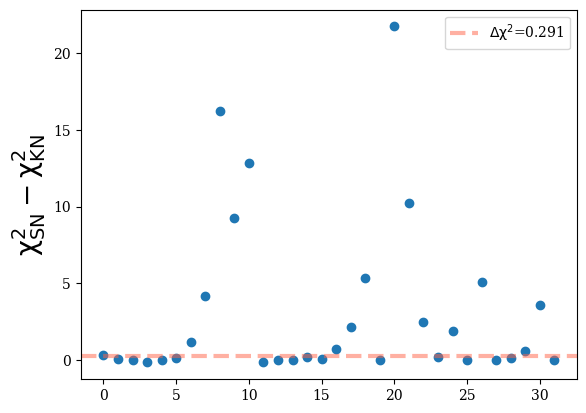

In [129]:
plt.plot(fitbl['sn_chisq']-fitbl['kn_chisq'], marker='o', ls='none')

delchisq = np.median(fitbl['sn_chisq']-fitbl['kn_chisq'])

plt.axhline(delchisq, ls='--', c='tomato', lw=3, alpha=0.5, label=r"$\rm \Delta{\chi^2}$"+f'={delchisq:1.3f}')

plt.ylabel(r'$\rm \chi^{2}_{SN}-\chi^{2}_{KN}$')
plt.legend()

In [196]:
obstbl = ascii.read('../5.result/kn_sim_cube_obs/sdss_40Mpc/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_sdss_obs_d40_iter100.sdss.ecsv')

indx_pick = np.where(
	(fitbl['obs']=='Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_sdss_obs_d40_iter100.sdss.ecsv') &
	(fitbl['t']==1.0)
)
pfitbl = fitbl[indx_pick]
#	Input Model
t = pfitbl['t'][0]
a = pfitbl['kn_popt'][0]

pobstbl = obstbl[obstbl['t']==t]

indx = np.where(times == t)
n = indx[0].item()
step = 1024

inobs = pfitbl['obs'][0]
inobspart = inobs.split('_')

angle = inobspart[-6].replace('angle', '')
ncol = int(((54/180)*120)+2)
inmdl = glob.glob(f"../3.table/kn_sim_cube_lite/{inobs.split('_angle')[0]}*fits")[0]
inmdltbl = Table.read(inmdl)
inmdltbl = inmdltbl[n*step:(n+1)*step]
flam = inmdltbl[f'col{ncol}']*(u.erg/u.second/u.Angstrom/u.cm**2)*a
lam = inmdltbl['lam']*u.Angstrom
fnu = convert_flam2fnu(flam, lam)
abmag = fnu.to(u.ABmag)

In [200]:
maglist = []
magerrlist = []

for filte in pobstbl.keys():
	if ('magapp_g' in filte) | ('magapp_r' in filte) | ('magapp_i' in filte):
		maglist.append(pobstbl[filte][0])
	if ('magerr_g' in filte) | ('magerr_r' in filte) | ('magerr_i' in filte):
		magerrlist.append(pobstbl[filte][0])

maglist = np.array(maglist)*u.ABmag
magerrlist = np.array(magerrlist)

In [201]:
magerrlist

array([0.1138707 , 0.1319057 , 0.10896622])

UnitsError: Can only add/subtract logarithmic units ofof compatible type.

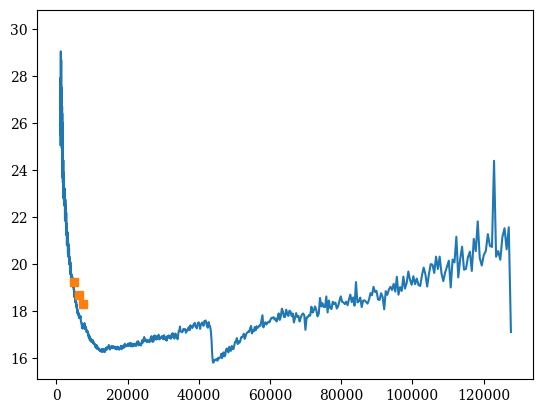

In [202]:
plt.plot(lam, abmag)
plt.errorbar(slam[:3], maglist, xerr=sbdw[:3]/2, yerr=magerrlist, ls='none', marker='s')
plt.xlim([3000, 10000])
plt.ylim([22, 16])